# **TP: Play with RNN**

---
With the following exercises, we will discover Recurrent neural networks (RNN) by building a character-level RNN classifying different names into different languages.

RNN considers the input as a sequence. In our example, it reads character by character of a surname. Each input character will output a hidden state and the previous hidden state will serve as an input for the prediction of the next hidden state -- recurrent networks. In the end, we will obtain a final output encoding all the information of all the characters in a surname, used to predict which language the surname belongs to.

Today's session consists of the following steps:
1.   Setup your coding environment with Google Colab,
2.   Data loading and pre-processing,
3.   Define an RNN and its loss function,
4.   Train the network on the train set,
5.   Evaluate your training performance,
6.   Bonus questions.

We will use *Pytorch* as our tool for this TP, a popular machine learning framework in the scientific world. Today's session is modified from its official tutorial by Sean Robertson.
Enjoy!


# 1. Setup with Colab
*Colab* notebooks offer an easy way to build and run your code online without installing dependencies locally. *Colab* works with *Jupyter Notebook — IPython*. We now set up our *Colab* environment step by step:


1).   go to [Colab](https://colab.research.google.com/notebooks/intro.ipynb?hl=en#scrollTo=GJBs_flRovLc),

2).   sign up with your google account and upload the notebook RNN_TP.ipynb,


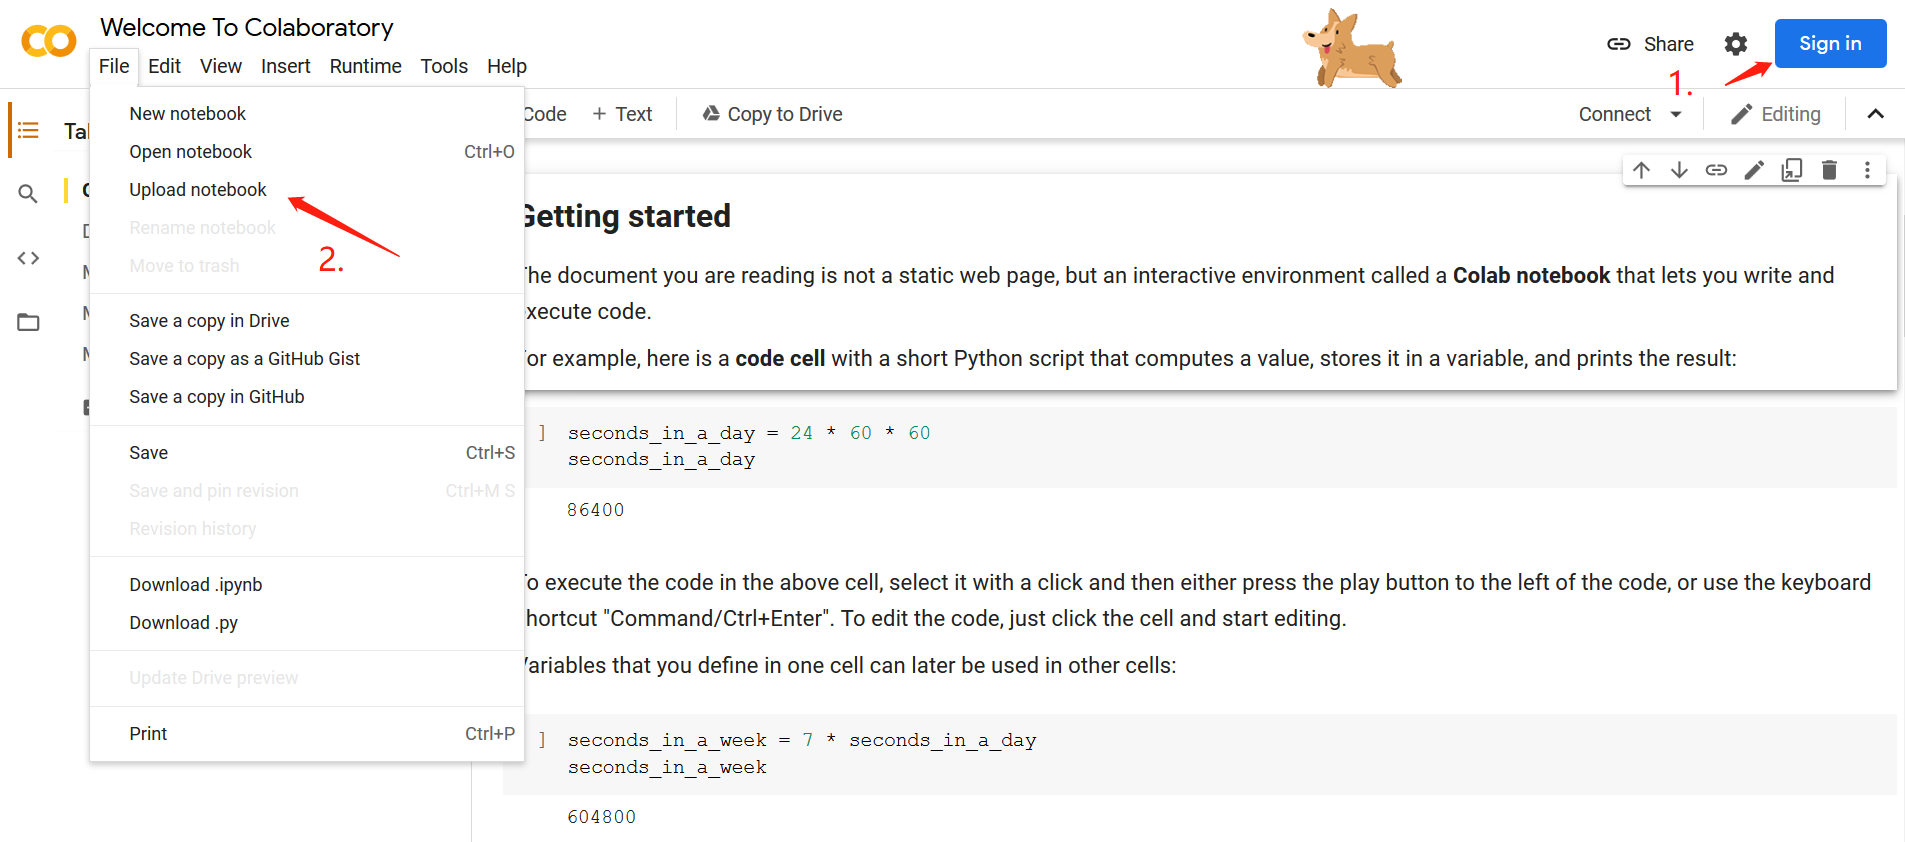


3). choose to run the code with the hosted runtime,
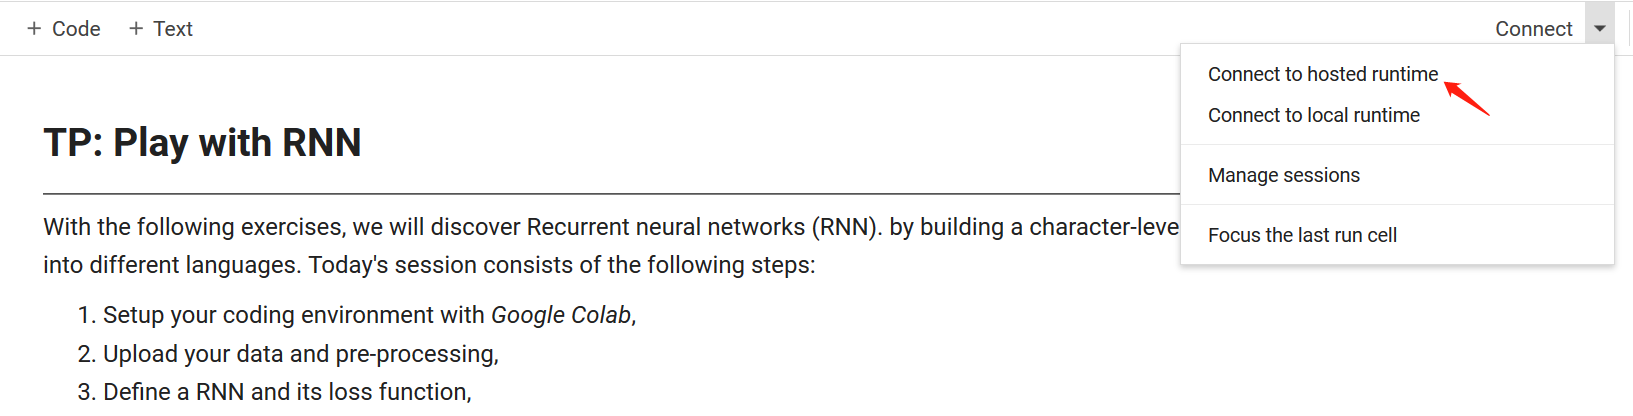


Normally, you can now run your code with *Colab* by clicking on the run button:

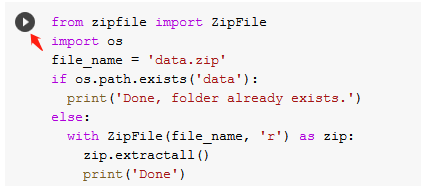

4). upload *data.zip*,

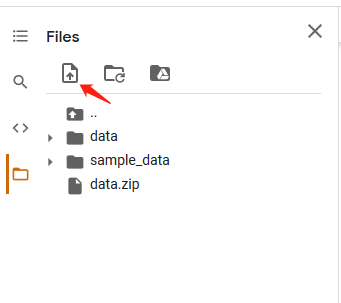


5). unzip the data.zip using the following code.

In [ ]:
from zipfile import ZipFile
import os
file_name = 'data.zip'
if os.path.exists('data'):
  print('Done, folder already exists.') 
else:
  with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print('Done')

Done


# 2. Data loading and pre-processing

## I. read data and remove the accents
The uploaded data contains 18 files with names as "[Language].txt", each file has many names, one name per line. To remove accents in the names, we need to convert the encoding from Unicode to ASCII.
In the following code, we will read the data, remove the accents of the names (Unicode to ASCII) and save them to a dictionary of format:

```
{language: [names ...]}
```

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

# collect all the letters in ASCII, will be used later
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    # unicodedata.normalize splits the character and the accent
    # and we filter out the accents.
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('François'))

# Build a dictionary named category_lines, 
# with key as a category (String), and value as a list of names (String)
# category_lines = {'French':['Paul', 'Sylvain'...], 'English': ['David'...], ...}
category_lines = {}
# Build a list of categories
# ['French', 'English'...]
all_categories = []

# Read a file and split into lines
def readLines(filename):
    # read all the lines (names) in a file and save it to a list.
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print("all_categories", all_categories)
print("category_lines", category_lines)

['data/names/Korean.txt', 'data/names/Portuguese.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt', 'data/names/Japanese.txt', 'data/names/French.txt', 'data/names/Dutch.txt', 'data/names/Chinese.txt', 'data/names/Irish.txt', 'data/names/Scottish.txt', 'data/names/Polish.txt', 'data/names/Arabic.txt', 'data/names/German.txt', 'data/names/Italian.txt', 'data/names/Czech.txt', 'data/names/Russian.txt', 'data/names/English.txt', 'data/names/Greek.txt']
Francois
all_categories ['Korean', 'Portuguese', 'Spanish', 'Vietnamese', 'Japanese', 'French', 'Dutch', 'Chinese', 'Irish', 'Scottish', 'Polish', 'Arabic', 'German', 'Italian', 'Czech', 'Russian', 'English', 'Greek']
category_lines {'Korean': ['Ahn', 'Baik', 'Bang', 'Byon', 'Cha', 'Chang', 'Chi', 'Chin', 'Cho', 'Choe', 'Choi', 'Chong', 'Chou', 'Chu', 'Chun', 'Chung', 'Chweh', 'Gil', 'Gu', 'Gwang ', 'Ha', 'Han', 'Ho', 'Hong', 'Hung', 'Hwang', 'Hyun ', 'Jang', 'Jeon', 'Jeong', 'Jo', 'Jon', 'Jong', 'Jung ', 'Kang', 'Kim', 'Ko', 'Koo

## II. embed each name into a tensor
We now have a dictionary named *category_lines* with languages as keys and lists of names as values. However, we need to convert each name into a tensor so that it can be input into the network.

Since we have converted each character into ASCII encoding, we can find the index of each character in the ASCII letters (*all_letters* saves all the ASCII letters into a list, in total 57 letters/characters.) 
 

In [ ]:
print("all ascii letters: ", all_letters)
print("number of ascii letters: ", n_letters)


all ascii letters:  abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
number of ascii letters:  57


Therefore, to embed a name, we can convert each character into a 57-long vector, where the values are all zero except a '1' at the index of the current character -- one-hot embedding. You might be lost. Let's try first to embed the letter 'K'.

In [ ]:
import torch
to_encode = 'K'
# initialize a torch tensor named 'embedding' with values all zero
embedding = torch.zeros(57)
# find the index of 'to_encode' from all_letters and set the embedding[index]=1
embedding[all_letters.index(to_encode)] = 1
print("'K' is in all_letters of index: ", all_letters.index(to_encode))
print("The embedding for 'K' is thus: ", embedding)


'K' is in all_letters of index:  36
The embedding for 'K' is thus:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])


Now, you know how to embed a character/letter. For a name, we can simply iterate the name and embed one by one each character. For example, for the name 'John', we can create a tensor of shape [4,1,57] where '4' means there are four characters in the name 'John' and '1' means one name, and '57' is the length of ASCII letters.

Could you know how to convert all the names into a tensor of shape [name_length x 1 x n_letters]?

In [ ]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter, n_letters=57):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line/name into a <name_length x 1 x n_letters>,
# using letterToTensor
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    
    for li, letter in enumerate(line):
        # to complete #
        tensor[li][0][letterToIndex(letter)] = 1      
    return tensor

print(letterToTensor('J'))

print(lineToTensor('John').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([4, 1, 57])


Great Job! You now manage to embed each name into a tensor. The next step is to build an RNN network.

# 3. Define an RNN and its loss function
## I. write your own (first) recurrent neural network
We are going to build a simple RNN having the following structure:

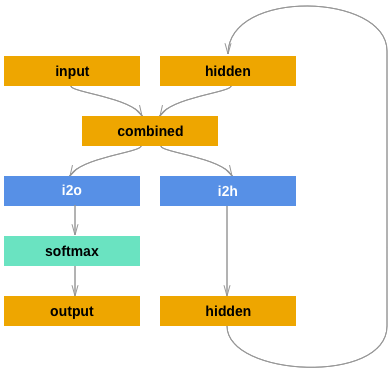



This RNN treats **one character** at a time. 

***input***: a character is fed into ***input***, of shape [1,input_size], *input_size* is the dimension of your character embedding, in our case, it is 57 since we embed each character into a one-hot ASCII tensor of length 57. 

***hidden***: a hidden state having shape [1, hidden_size], hidden_size is fixed and pre-defined.

***combined***: we concatenate [***input***, ***hidden***] to form a combined tensor of shape [1, input_size+hidden_size].

**i2o**: a fully-connected (Linear) layer that projects the combined tensor into output, since we are classifying names into 18 languages, the #input channels = input_size+hidden_size, the #output channels is n_categories=18.

**i2h**: a fully-connected (Linear) layer that projects the combined tensor into next hidden state, thus having the #input channels = input_size+hidden_size, #output channels = hidden_size.

***softmax***: a **logSoftmax** function normalizing the output of **i2o**.



In [ ]:
import torch.nn as nn
torch.manual_seed(1)

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        # define i2h
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        # define i2o
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        # define a logSoftmax function
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # following the graph and build the RNN by connecting the bricks defined at __init__.
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        ## init a hidden state of values zero.
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
# creat an instance of class RNN
rnn = RNN(n_letters, n_hidden, n_categories)

Let's try to input an embedded character into the network and see what's the values of the output.

In [ ]:
name = 'Coucou'
# build the embedding using lineToTensor
input = lineToTensor(name)
# init the hidden state using rnn.initHidden
hidden = rnn.initHidden()

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8464, -2.8364, -2.8932, -2.9273, -2.9784, -2.7951, -2.9400, -2.9048,
         -2.9038, -2.8498, -2.8788, -2.8115, -2.9881, -2.8995, -2.9340, -2.8757,
         -2.9676, -2.8242]], grad_fn=<LogSoftmaxBackward>)


As you can see, the output is a [1, n_categories] Tensor, where every item is the likelihood of that category (higher is more likely). Using the output, we can find its predicted class by indexing the maximum likelihood and use the index to locate the correct category in *all_categories*, the dictionary that we created containing the data with the category as key and list of names as value. 

In [ ]:
# define a function that can find the class from the output
def categoryFromOutput(output):
    # suppose that the output is a torch tensor of shape [1, n_categories],
    ## find the maximum value and index in the output.
    top_n, top_i = torch.max(output, dim=1)
    category_i = top_i.item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('French', 5)


## II. define loss function for classification

Bravo! You managed to build your own network! Let's move forward: define a training loss for classification. A loss function is used for minimizing the errors of your predictions using the gradient descent method by an optimizer. For classification, a classic loss is [*Cross Entropy loss*](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?highlight=nn%20crossentropyloss#torch.nn.CrossEntropyLoss):

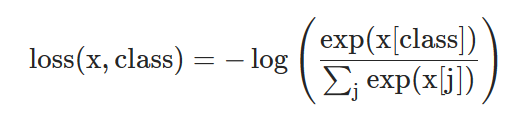


**x** is the predicted logics of shape [batch size, #classes], we can normalize it with a [*softmax* ](https://en.wikipedia.org/wiki/Softmax_function)function (!!warning!! this is already done in the [*nn.CrossEntropyLoss*](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?highlight=nn%20crossentropyloss#torch.nn.CrossEntropyLoss) in Pytorch.i.e. You don't need to apply the softmax function using *nn.CrossEntropyLoss*) which scales the prediction of each class to [0,1] and makes the sum of them to 1 ( An animal cannot be a dog and cat at the same time).

**class** of shape [batch size] is the target class index (starting from 0) of each element in the output.

By minimizing the loss function, we can see from the equation that we are optimizing the probabilities of the target classes.

Since **we already applied the logSoftMax to the output**, we can use negative log-likelihood loss [nn.NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html?highlight=nllloss#torch.nn.NLLLoss), which picks the x[class] according to its target class label and applies the negative operation to the log-likelihood:

```
criterion = nn.NLLLoss()
```




In [ ]:
# define the loss function as nn.NLLLoss()
criterion = nn.NLLLoss()

# 4. Train the network on the train set

We are about to train our RNN with the data. Before doing that, we define some functions that can randomly select a name and its language from the data.


In [ ]:
import random
random.seed(1)

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print("category_tensor.shape", category_tensor.shape)
    print("line_tensor.shape", line_tensor.shape)
    print('category =', category, '/ line =', line)

category_tensor.shape torch.Size([1])
line_tensor.shape torch.Size([11, 1, 57])
category = Japanese / line = Nishimuraya
category_tensor.shape torch.Size([1])
line_tensor.shape torch.Size([7, 1, 57])
category = Spanish / line = Herrera
category_tensor.shape torch.Size([1])
line_tensor.shape torch.Size([3, 1, 57])
category = Vietnamese / line = Ton
category_tensor.shape torch.Size([1])
line_tensor.shape torch.Size([5, 1, 57])
category = Czech / line = Vlach
category_tensor.shape torch.Size([1])
line_tensor.shape torch.Size([4, 1, 57])
category = German / line = Groe
category_tensor.shape torch.Size([1])
line_tensor.shape torch.Size([2, 1, 57])
category = Vietnamese / line = To
category_tensor.shape torch.Size([1])
line_tensor.shape torch.Size([3, 1, 57])
category = Korean / line = Noh
category_tensor.shape torch.Size([1])
line_tensor.shape torch.Size([5, 1, 57])
category = Italian / line = Sessa
category_tensor.shape torch.Size([1])
line_tensor.shape torch.Size([3, 1, 57])
category = Ko

We would like to define a train function that 


1.   inputs: the network *rnn*, the *criterion*, *category_tensor* and *line_tensor* (from *randomTrainingExample* function defined above),
2.   produces the predicted output using *rnn*,
2.   calculates the loss with *criterion*, 
3.   updates the network weights,
4.   returns the predicted output and the loss value.

In [ ]:
learning_rate = 0.005
# train function for one iteration
def train(category_tensor, line_tensor):
    # init the hidden sate
    hidden = rnn.initHidden()

    # clean gradients
    rnn.zero_grad()

    # line_tensor is of shape [len_name, 1, 57],
    # intput the name to rnn character by character, recurrent the hidden states
    # and get the final output
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

With the *train* function, we can start training the network:

In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

# show train time
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    # get category, line, category_tensor, line_tensor using randomTrainingExample()
    category, line, category_tensor, line_tensor = randomTrainingExample()
    # train the network using train()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
# save the model
torch.save(rnn.state_dict(), './rnn_model.pth')

5000 5% (0m 7s) 2.2653 Delgado / Portuguese ✓
10000 10% (0m 14s) 0.2388 Koustoubos / Greek ✓
15000 15% (0m 21s) 1.2111 Haritoshkin / Russian ✓
20000 20% (0m 29s) 1.1014 Kitamura / Japanese ✓
25000 25% (0m 36s) 1.3560 Favre / French ✓
30000 30% (0m 43s) 1.6040 Zhou / Korean ✗ (Chinese)
35000 35% (0m 51s) 3.4914 Chan / Irish ✗ (English)
40000 40% (0m 58s) 2.6222 Sappe / French ✗ (Czech)
45000 45% (1m 5s) 4.1771 Maas / Vietnamese ✗ (German)
50000 50% (1m 12s) 2.1055 Roux / Arabic ✗ (French)
55000 55% (1m 19s) 0.6904 Macleod / Scottish ✓
60000 60% (1m 27s) 0.2500 Mcgregor / Scottish ✓
65000 65% (1m 34s) 2.1461 Cruz / Spanish ✗ (Portuguese)
70000 70% (1m 41s) 1.3945 Weldon / Scottish ✗ (English)
75000 75% (1m 48s) 0.9252 Rotolo / Italian ✓
80000 80% (1m 56s) 1.0176 Heatley / English ✓
85000 85% (2m 3s) 4.0976 Sano / Korean ✗ (Japanese)
90000 90% (2m 10s) 0.4605 Ryom / Korean ✓
95000 95% (2m 17s) 0.0569 Varvitsiotes / Greek ✓
100000 100% (2m 25s) 0.8634 Deng / Chinese ✓


We can visualize the training as follows:

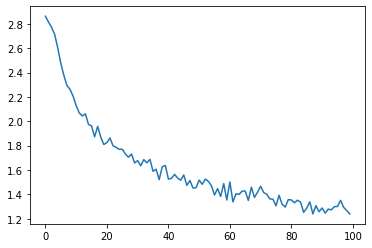

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Not bad! Your loss was descreasing!

# 5. Evaluate your training performance
## I. Confusion Matrix 
We can build a confusion matrix where rows are actual language (rows) which language the network guesses (columns), i.e. 

```
confusion matrix[i,j] += 1 if actual language i is predicted as category j, 
i=0,1,2,3...99, j=0,1,2,3,...99.
```


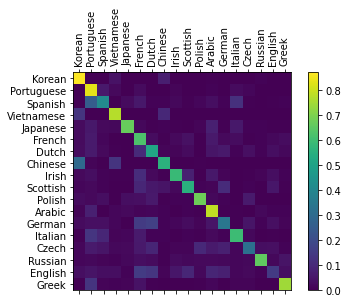

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
# Number of training examples
n_confusion = 10000

# write a function 'evaluate' returning an output given a line, 
# same as train() but without updating the network weights
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    # randomly pick a name using randomTrainingExample()
    category, line, category_tensor, line_tensor = randomTrainingExample()
    # return an output given a line_tensor using evaluate()
    output = evaluate(line_tensor)
    # find the guess with the maximum likelihood
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## II. play with your model

Let's now write a function *predict* that can take a name, of type String, as the input, and output its top3 possible categories as well as probabilities.

In [ ]:
import numpy as np
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        # use evaluate() to get the output
        # you can use lineToTensor to embed your name in 
        # String to a tensor of shape [#characters, 1, 57]
        output = evaluate(lineToTensor(input_line))

        # Get top N=3 categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (np.exp(value), all_categories[category_index]))
            predictions.append([np.exp(value), all_categories[category_index]])


In [ ]:
# try to predict the language of your name using predict()!
predict('Mahmoud')


> Mahmoud
(0.96) Arabic
(0.01) French
(0.01) Russian
